In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("imported")
import random
import os
import sys
import itertools
sys.path.append('src/')
import nn
import process_data
import nibabel as nib
from math import floor, ceil
# import cv2

from __future__ import division, print_function, absolute_import
from sklearn.metrics import confusion_matrix
import scipy.sparse
from scipy.misc import imrotate, imresize
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate
from skimage import exposure
from skimage.io import imread, imsave

imported


In [2]:
def empty_img(img):
    """
    Returns True if the image is empty -> only 0s.
    """
    return not np.count_nonzero(img)

def split_filename(filename):
    """
    Splits filename for a trial into 'trial10_30_w1', True if seg[label], False if vol[raw]
    """
    fn_lst = filename.split('_')
    if len(fn_lst) >= 4:
        trial_name = "_".join(fn_lst[:3])
        if 'seg' in fn_lst[3]:  
            return trial_name, True
        elif 'vol' in fn_lst[3]:
            return trial_name, False
    else:
        return None, None

In [3]:
def bounding_box(img):
    """
    Returns copy of the img bounded by the box from the image.
    """

    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    box = im[rmin : rmax, cmin : cmax]
    return box

In [4]:
def build_image_dataset(trial_key, raw_nii, label_nii, base_data_dir, base_img_data_dir):
    raw_nii_file = os.path.join(base_data_dir, raw_nii)
    label_nii_file = os.path.join(base_data_dir, label_nii)
    raw_voxel = nib.load(raw_nii_file).get_data()
    label_voxel = nib.load(label_nii_file).get_data()
    
    counter = 0
    trial_img_dir = os.path.join(base_img_data_dir, trial_key)
    if not os.path.exists(trial_img_dir):
        os.makedirs(trial_img_dir)
    raw_clean_voxel, labeled_clean_voxel = None, None
    for i in range(raw_voxel.shape[0]):  # shape is (1188, 482, 395)
        if empty_img(raw_voxel[i]) or empty_img(label_voxel[i]):
            continue
            
        raw_img = raw_voxel[i]
        labeled_img = fill(label_voxel[i])  # Grid fill the labeled image
        
        scipy.misc.imsave(os.path.join(trial_img_dir, str(counter) + '_raw.png'), raw_img)
        scipy.misc.imsave(os.path.join(trial_img_dir, str(counter) + '_label.png'), labeled_img)
        
        counter += 1

# Slicing




In [6]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray",origin="lower")

# Horizontal Slices

In [7]:
img = nib.load('/Users/saimandava/Desktop/90deg_nifti/trial18_90_fs_seg_TRANS.nii')

In [8]:
img_data = img.get_fdata()

In [10]:
img_data.shape

(1188, 482, 395)

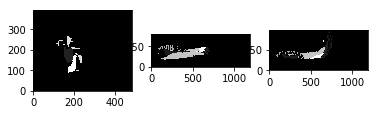

In [14]:
show_slices([img_data[182, :, :],img_data[:, 178, :],img_data[:, :, 198]])

In [18]:
#need to slice nifti images from each different direction: nsew
#TODO: figure out rotations without data loss
#TODO tmrw: make sure to slice the images without hardcoding and be able to take in a random nift file and slice accordingly
#CANNOT HAVE BLACKNESS

